In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
# importovanie potrebných knižníc

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

/var/folders/lc/0tq3t3m97j18yp2pgzc9h2vw0000gn/T/ipykernel_15677/3442531515.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# inštalácia balíkov python
%pip install mlxtend
%pip install - -upgrade pip
%pip install networkx

Note: you may need to restart the kernel to use updated packages.

Usage:   
  /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install [options] <requirement specifier> [package-index-options] ...
  /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install [options] -r <requirements file> [package-index-options] ...
  /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install [options] [-e] <vcs project url> ...
  /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install [options] [-e] <local project path> ...
  /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install [options] <archive url/path> ...

no such option: -u
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# načitanie datasetu
df = pd.read_csv("stroke_data.csv")
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [4]:
# odstránenie stĺpca "id"
df = df.drop(columns=['id'])

In [5]:
# premenovanie atribútov z angličtiny do slovenčiny
df = df.rename(columns={'age': 'vek'})
df = df.rename(columns={'heart_disease': 'srdcova_choroba'})
df = df.rename(columns={'work_type': 'typ_prace'})
df = df.rename(columns={'smoking_status': 'fajcenie'})
df = df.rename(columns={'stroke': 'mrtvica'})
df = df.rename(columns={'Residence_type': 'typ_rezidencie'})
df = df.rename(columns={'avg_glucose_level': 'priemerna_hladina_glukozy'})
df = df.rename(columns={'gender': 'pohlavie'})
df = df.rename(columns={'ever_married': 'manželstvo'})
df = df.rename(columns={'hypertension': 'krvny_tlak'})

In [6]:
# zobrazenie prvých 5 riadkov datasetu
df.head(5)

,pohlavie,vek,krvny_tlak,srdcova_choroba,manželstvo,typ_prace,typ_rezidencie,priemerna_hladina_glukozy,bmi,fajcenie,mrtvica
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [7]:
# nahradenie chýbajúcich hodnôt v stĺpci "bmi" priemerom všetkých hodnôt v tomto stĺpci
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

/var/folders/lc/0tq3t3m97j18yp2pgzc9h2vw0000gn/T/ipykernel_15677/3647075269.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].mean(), inplace=True)


In [8]:
# prevedenie textových hodnôt na číselné
df["pohlavie"] = df["pohlavie"].replace({"Male":0, "Female":1})
df["manželstvo"] = df["manželstvo"].replace({"No":0, "Yes":1})
df["fajcenie"] = df["fajcenie"].replace({"Unknown":0, "smokes":1, "formerly smoked":2, "never smoked":3 })
df["typ_prace"] = df["typ_prace"].replace({"Private":0, "Self-employed":1, "Govt_job":2})
df["typ_rezidencie"] = df["typ_rezidencie"].replace({"Urban":0, "Rural":1})

/var/folders/lc/0tq3t3m97j18yp2pgzc9h2vw0000gn/T/ipykernel_15677/1893360737.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["manželstvo"] = df["manželstvo"].replace({"No":0, "Yes":1})
/var/folders/lc/0tq3t3m97j18yp2pgzc9h2vw0000gn/T/ipykernel_15677/1893360737.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["fajcenie"] = df["fajcenie"].replace({"Unknown":0, "smokes":1, "formerly smoked":2, "never smoked":3 })
/var/folders/lc/0tq3t3m97j18yp2pgzc9h2vw0000gn/T/ipykernel_15677/1893360737.py:6: FutureWarning: Downcasting b

In [9]:
# prevod kategorických na číselné hodnoty
df['pohlavie'], _ = pd.factorize(df['pohlavie'])
df['typ_prace'], _ = pd.factorize(df['typ_prace'])

In [10]:
# prevedenie hodnôt na celé čísla
df['vek'] = df['vek'].astype('int64')
df['priemerna_hladina_glukozy'] = df['priemerna_hladina_glukozy'].astype('int64')
df['bmi'] = df['bmi'].astype('int64')

In [11]:
df.head(5)

,pohlavie,vek,krvny_tlak,srdcova_choroba,manželstvo,typ_prace,typ_rezidencie,priemerna_hladina_glukozy,bmi,fajcenie,mrtvica
0,0,67,0,1,1,0,0,228,36,2,1
1,1,61,0,0,1,1,1,202,28,3,1
2,0,80,0,1,1,0,1,105,32,3,1
3,1,49,0,0,1,0,0,171,34,1,1
4,1,79,1,0,1,1,1,174,24,3,1


In [12]:
# vstupné premenné
X = df.drop("mrtvica", axis=1)

# škálovanie vstupných premenných pomocou StandardScaler - pre algoritmy citlivé na mierku dát
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# zistenie optimálneho počtu zhlukov pomocou Silhouette Score pre K-Means
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimálny počet zhlukov: {optimal_k}")

Optimálny počet zhlukov: 3


In [14]:
# trénovanie K-Means s optimálnym počtom zhlukov
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

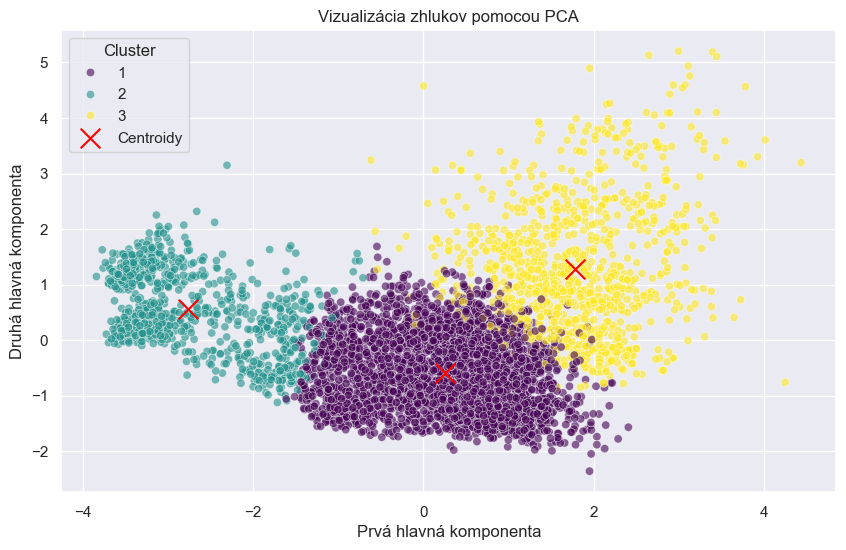

In [15]:
# PCA redukcia dimenzionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# zobrazenie zhlukov s novými označeniami
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'] + 1, palette='viridis', alpha=0.6)

# zobrazenie centroidov
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='x', s=200, label='Centroidy')

plt.title('Vizualizácia zhlukov pomocou PCA')
plt.xlabel('Prvá hlavná komponenta')
plt.ylabel('Druhá hlavná komponenta')
plt.legend(title='Cluster')
plt.show()

In [16]:
# overenie cieľového atribútu v zhlukoch s novými označeniami
for i in range(optimal_k):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    cluster_labels = df.iloc[cluster_indices]['mrtvica'].unique()
    print(f"Zhluk {i + 1} obsahuje hodnoty atribútu 'mrtvica': {cluster_labels}")
    if len(cluster_labels) == 1:
        print(f"Zhluk {i + 1} obsahuje iba osoby s hodnotou {cluster_labels[0]} pre atribút 'mrtvica'.")
        print("-----------------------------------------------------------------")
    else:
        print(f"Zhluk {i + 1} obsahuje osoby s rôznymi hodnotami atribútu 'mrtvica'.")
        print("-----------------------------------------------------------------")

Zhluk 1 obsahuje hodnoty atribútu 'mrtvica': [1 0]
Zhluk 1 obsahuje osoby s rôznymi hodnotami atribútu 'mrtvica'.
-----------------------------------------------------------------
Zhluk 2 obsahuje hodnoty atribútu 'mrtvica': [1 0]
Zhluk 2 obsahuje osoby s rôznymi hodnotami atribútu 'mrtvica'.
-----------------------------------------------------------------
Zhluk 3 obsahuje hodnoty atribútu 'mrtvica': [1 0]
Zhluk 3 obsahuje osoby s rôznymi hodnotami atribútu 'mrtvica'.
-----------------------------------------------------------------


In [17]:
# vypočítanie priemeru výskytu mŕtvice 
average_stroke_rate = df['mrtvica'].mean()

# identifikácia rizikových skupín na základe vyššej mierky výskytu mŕtvice ako priemertu sa vraciam k mrtvici, kedže zisťujem rizikove skupiny pacientov
risk_clusters = []
for i in range(optimal_k):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    cluster_stroke_rate = df.iloc[cluster_indices]['mrtvica'].mean()
    if cluster_stroke_rate > average_stroke_rate:
        risk_clusters.append(i)

# výpis identifikovaných rizikových skupín a ich atribútov
if risk_clusters:
    print("------------------------------------------------------------")
    print("Identifikované rizikové skupiny:")
    for cluster in risk_clusters:
        print(f"Zhluk {cluster + 1} má vyššiu mieru výskytu mŕtvice ako celkový priemer.")
        print("------------------------------------------------------------")
        print("Atribúty v tejto rizikovej skupine:")
        print("---------------------------------------")
        cluster_indices = np.where(kmeans.labels_ == cluster)[0]
        cluster_attributes = X.iloc[cluster_indices].mean()
        cluster_attributes['pohlavie'] = df['pohlavie'].replace({0: "Male", 1: "Female"})[int(cluster_attributes['pohlavie'])]
        cluster_attributes['manželstvo'] = df['manželstvo'].replace({0: "No", 1: "Yes"})[int(cluster_attributes['manželstvo'])]
        cluster_attributes['typ_prace'] = df['typ_prace'].replace({0: "Private", 1: "Self-employed", 2: "Govt_job"})[int(cluster_attributes['typ_prace'])]
        cluster_attributes['typ_rezidencie'] = df['typ_rezidencie'].replace({0: "Urban", 1: "Rural"})[int(cluster_attributes['typ_rezidencie'])]
        cluster_attributes['fajcenie'] = df['fajcenie'].replace({0: "Unknown", 1: "smokes", 2: "formerly smoked", 3: "never smoked"})[int(cluster_attributes['fajcenie'])]
        cluster_attributes['krvny_tlak'] = df['krvny_tlak'].replace({0: "Normal", 1: "High"})[int(cluster_attributes['krvny_tlak'])]
        cluster_attributes['srdcova_choroba'] = df['srdcova_choroba'].replace({0: "No", 1: "Yes"})[int(cluster_attributes['srdcova_choroba'])]
        print(cluster_attributes)
        print("---------------------------------------")
else:
    print("Žiadne rizikové skupiny neboli identifikované.")



------------------------------------------------------------
Identifikované rizikové skupiny:
Zhluk 3 má vyššiu mieru výskytu mŕtvice ako celkový priemer.
------------------------------------------------------------
Atribúty v tejto rizikovej skupine:
---------------------------------------
pohlavie                             Male
vek                              63.30964
krvny_tlak                         Normal
srdcova_choroba                       Yes
manželstvo                            Yes
typ_prace                         Private
typ_rezidencie                      Urban
priemerna_hladina_glukozy      156.976631
bmi                             32.107108
fajcenie                     never smoked
dtype: object
---------------------------------------


/var/folders/lc/0tq3t3m97j18yp2pgzc9h2vw0000gn/T/ipykernel_15677/637180698.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Male' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  cluster_attributes['pohlavie'] = df['pohlavie'].replace({0: "Male", 1: "Female"})[int(cluster_attributes['pohlavie'])]
